1 Physical GPUs, 1 Logical GPU
Found 27000 files belonging to 10 classes.
Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 23ms/step
Confusion Matrix, without normalization
[[ 947    4   12   15    0   25   31    0   17   21]
 [   0 1010   16    0    0   31    0    0    1    7]
 [   1   13  977    8    5   19   56    2    0    0]
 [   3    0    4  820   34    3    4    3   10    0]
 [   0    0   11   12  862    0    2   17    0    0]
 [   2    7   29    6    0  631   18    0    5    7]
 [  26    0   60   54    7   16  711    5    7    0]
 [   0    0   14    4   37    1    2 1019    0    0]
 [  20    5   12   37    1   18    3    0  795    6]
 [   0    9    2    0    0    2    0    0    5 1038]]


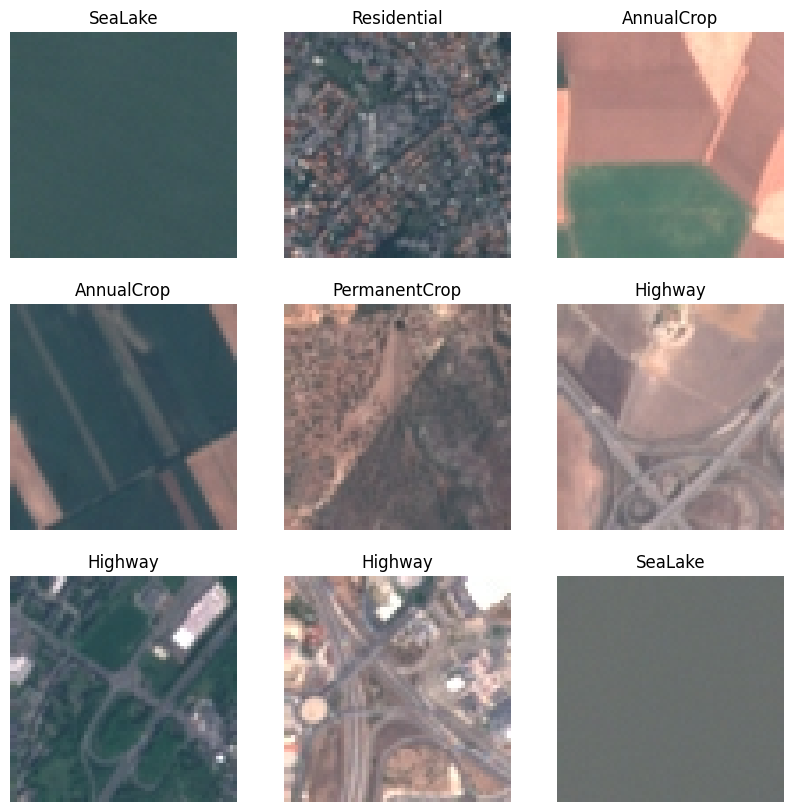

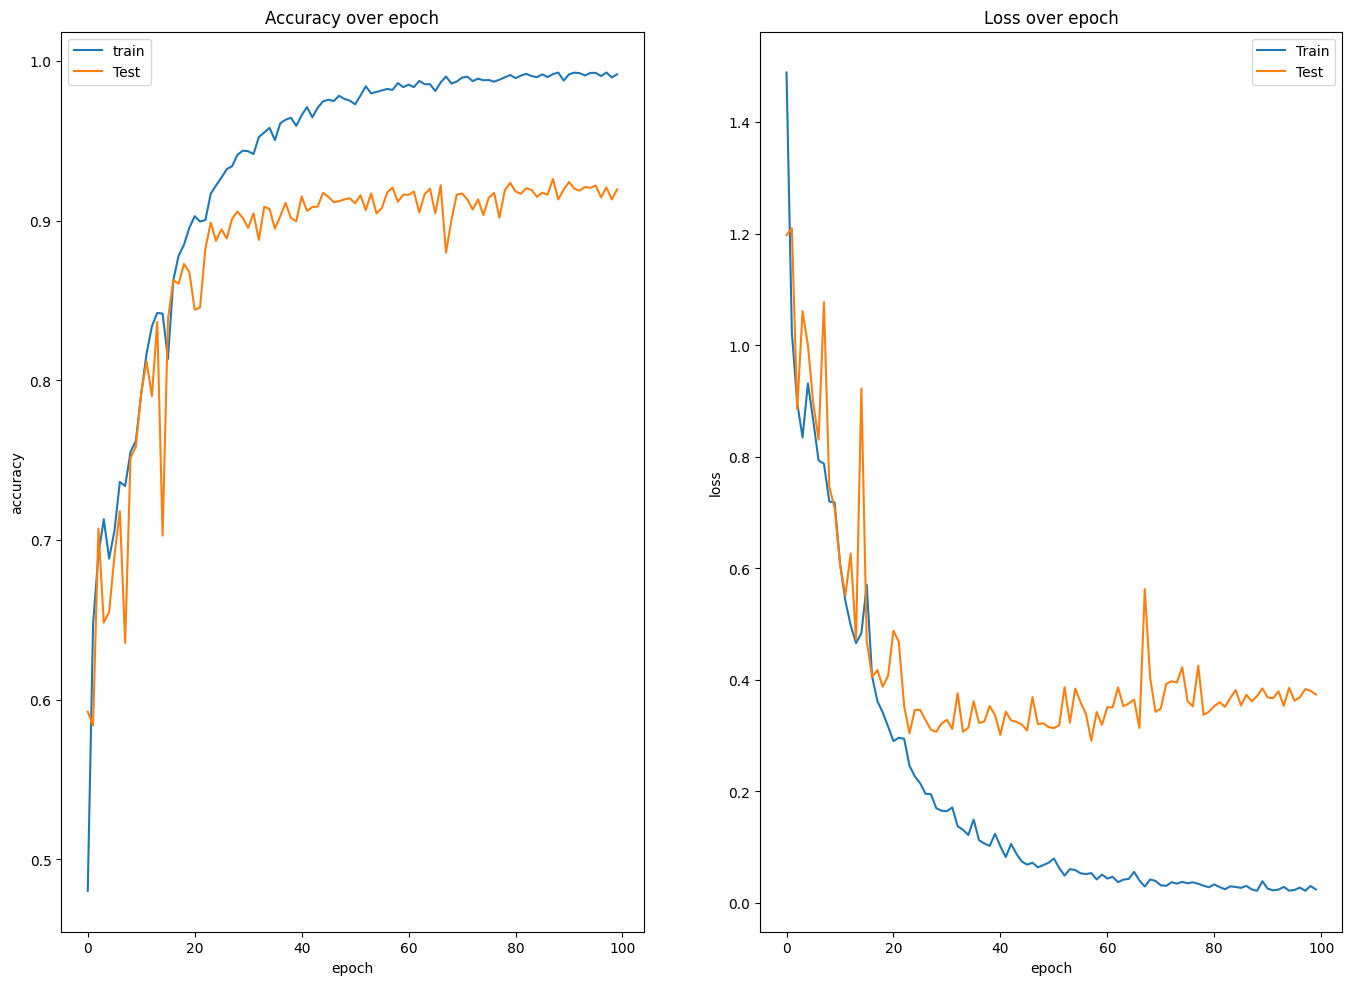

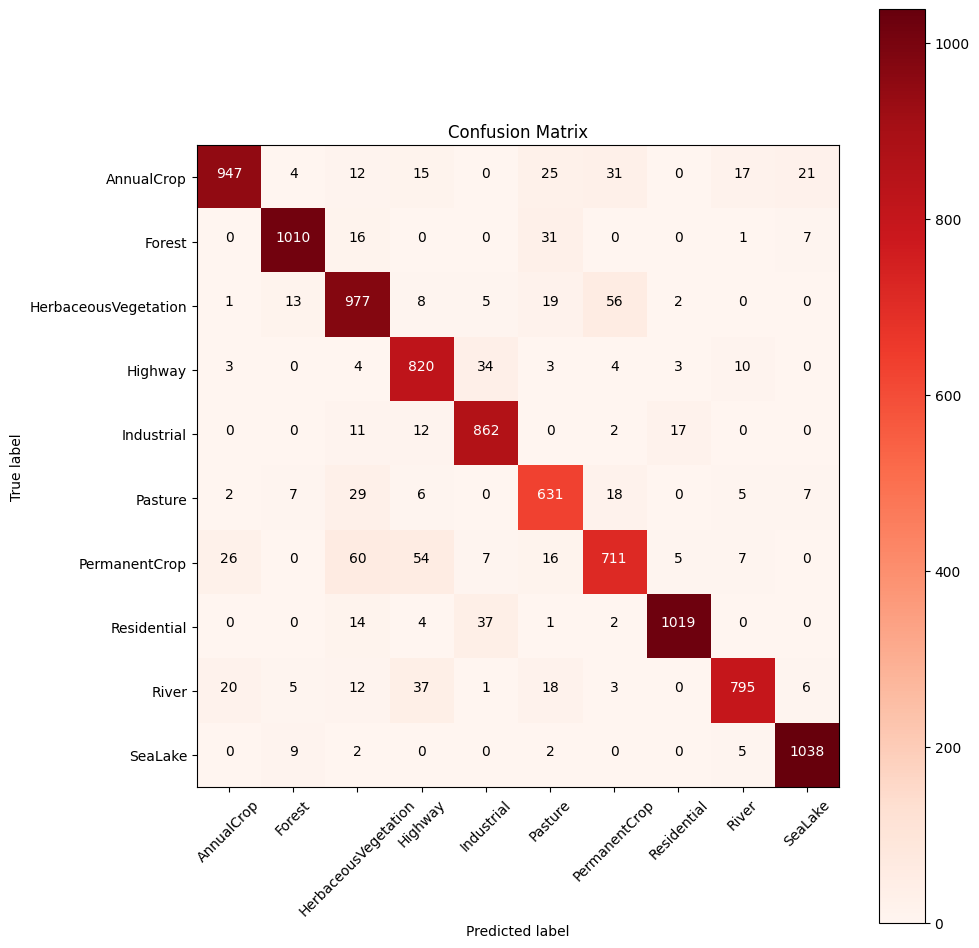

In [2]:
import os
import glob

#plots
import matplotlib.pyplot as plt

import numpy as np

import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

import itertools
from sklearn.metrics import confusion_matrix

# Check if GPU is available and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

# Your code
dataset_url = "/kaggle/input/eurosat10-classes/EuroSAT_RGB"
batch_size = 32
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0/255

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.utils.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                            directory = dataset_url,
                                            shuffle = True,
                                            target_size = (img_height, img_width),
                                            subset = "training",
                                            class_mode = 'categorical')

test_dataset = datagen.flow_from_directory(batch_size= batch_size,
                                           directory = dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset = "validation",
                                           class_mode = 'categorical')
class_names = dataset.class_names
plt.figure(figsize=(10,10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import random_uniform

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block.

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle Conv's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode, False: Behave in inference mode
    initializer -- kernel initializer to set up the initial weights of a layer. Defaults to random uniform initializer.

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of the main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Adjust the shape of the shortcut connection
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to the main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    

    # Retrieve filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # Main path
    # First component of the main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding="valid", kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to the main path and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
def ResNet50(input_shape = (64, 64, 3), classes = 6):
  """
  stage-wise implementation of the architecture of the popular ResNet50

    """

  #define the input as a tensor with shape input_shape
  X_input = Input(input_shape)

  #zero-padding
  X = ZeroPadding2D((3, 3))(X_input)

  #Stage 1
  X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides =(2, 2))(X)

  #stage 2
  X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
  X = identity_block(X, 3, [64, 64, 256])
  X = identity_block(X, 3, [64, 64, 256])

  #stage 3 (=4 lines)
  X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
  X = identity_block(X, 3, [128, 128, 512])
  X = identity_block(X, 3, [128, 128, 512])
  X = identity_block(X, 3, [128, 128, 512])

  #stage 4 (=6 lines)
  X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])

  #stage 5 (=3 lines)
  X = convolutional_block(X, f = 3, filters = [512, 512, 2038], s = 2)
  X = identity_block(X, 3, [512, 512, 2048])
  X = identity_block(X, 3, [512, 512, 2048])

  #AVGPOOL (=1 line). Use "X = averagepooling2D(...)(X)"
  X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)

  #output layer
  X = Flatten()(X)
  X = Dense(classes, activation = 'softmax', kernel_initializer = glorot_uniform(seed=0))(X)

  #create model
  model = Model(inputs = X_input, outputs = X)

  return model
model = ResNet50(input_shape=(64, 64, 3), classes = 10)
model.summary()

# Import the necessary module
from tensorflow.compat.v1 import train


# Change the optimizer instantiation
model.compile(optimizer=train.AdamOptimizer(), loss='categorical_crossentropy', metrics=['accuracy'])

#please increase the epoch for higher accuracy(epoch = 100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs = 100, batch_size = 32)

model.save(r'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

from tensorflow.keras.models import load_model
model = load_model(r"vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['train', 'Test'], loc = "upper left")

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc = "upper right")

y_pred = [] #store predicted labels
y_true = [] #store true labels

#iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):    #use dataset.unbatch() with repeat

#append true labels
        y_true.append(label_batch)

#compute prediction
        preds = model.predict(image_batch)

#append predicted labels
        y_pred.append(np.argmax(preds, axis = 1))
        if i==300:
              break

#convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
cm

import numpy as np
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          figsize=(10, 10),
                          cmap=plt.cm.Blues):

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):  # Corrected range(cm.shape)
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage:
# plot_confusion_matrix(confusion_matrix, classes=['Class 0', 'Class 1'], normalize=True)
plot_confusion_matrix(cm, train_dataset.class_indices, cmap = 'Reds')